In [2]:
! pip install keras_tuner
! pip install keras

     |████████████████████████████████| 129 kB 2.5 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner
import keras

In [4]:
csv_file_path = './airbnb_dataset/milestone3.csv'
df = pd.read_csv(csv_file_path)
pd.set_option('display.max_columns', None)
df.head()

,log_price,property_type,accommodates,bathrooms,host_response_rate,bedrooms,beds,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cleaning_fee_True,host_has_profile_pic_t,property_type_encoded,des_sentiment_analysis,name_sentiment_analysis
0,5.010635,Apartment,-0.072621,-0.404046,0.296013,-0.312048,-0.566461,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,True,-0.245434,0.216242,-0.435248
1,5.129899,Apartment,1.783653,-0.404046,0.296013,2.034955,1.027816,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,True,-0.245434,0.837002,-1.788095
2,4.976734,Apartment,0.855516,-0.404046,0.296013,-0.312048,1.027816,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,True,True,-0.245434,0.808508,-0.133695
3,6.620073,House,0.391448,-0.404046,0.296013,0.861454,0.230678,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,True,0.158745,0.213627,-0.926212
4,4.744932,Apartment,-0.536689,-0.404046,0.296013,-1.485549,-0.566461,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,True,True,-0.245434,-0.101872,-0.095776


In [5]:
features = [col for col in df.columns if col != 'log_price' and df[col].dtype in ['int64', 'float64']]
X = df[features]
y = df['log_price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train with NN

In [7]:
# Uncomment below if tensorflow is not installed already
#%pip install tensorflow
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
# Build Neural Network
nn_model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
# add validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [69]:
# Train the model
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1479/1479 [==============================] - 1s 938us/step - loss: 0.2182 - val_loss: 0.2152
Epoch 2/10
1479/1479 [==============================] - 1s 778us/step - loss: 0.2172 - val_loss: 0.2219
Epoch 3/10
1479/1479 [==============================] - 1s 735us/step - loss: 0.2173 - val_loss: 0.2130
Epoch 4/10
1479/1479 [==============================] - 1s 839us/step - loss: 0.2167 - val_loss: 0.2241
Epoch 5/10
1479/1479 [==============================] - 1s 818us/step - loss: 0.2161 - val_loss: 0.2138
Epoch 6/10
1479/1479 [==============================] - 1s 853us/step - loss: 0.2171 - val_loss: 0.2136
Epoch 7/10
1479/1479 [==============================] - 1s 863us/step - loss: 0.2164 - val_loss: 0.2157
Epoch 8/10
1479/1479 [==============================] - 1s 777us/step - loss: 0.2157 - val_loss: 0.2153
Epoch 9/10
1479/1479 [==============================] - 1s 857us/step - loss: 0.2155 - val_loss: 0.2134
Epoch 10/10
1479/1479 [==============================] - 1s 792u

In [70]:
# Evaluate the model
mse = nn_model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {mse}")

463/463 [==============================] - 0s 468us/step - loss: 0.2175
Mean Squared Error on Test Set: 0.21753966808319092


In [136]:
y_pred = nn_model.predict(X_test)
y_pred

463/463 [==============================] - 0s 391us/step


array([[4.6656137],
       [5.10002  ],
       [5.3212247],
       ...,
       [4.243773 ],
       [4.540394 ],
       [5.0320325]], dtype=float32)

In [138]:
import seaborn as sns
  
# Plot the residuals
def plot_residuals(df_plot, save = False):
  plt.figure(figsize=(10, 6))
  
  # Plot the residuals
  sns.scatterplot(x='Predicted', y='Residuals', data=df_plot, alpha=0.5)
  
  plt.title('Sampled Residuals vs. Predicted Values')
  plt.xlabel('Predicted Values')
  plt.ylabel('Sampled Residuals')
  
  # Add a horizontal line at y = 0
  plt.axhline(y=0, color='red', linestyle='--') 
  
  
  if save:
    plt.savefig('graphs/residuals.png')
    
    
  plt.show()
  
  
def plot_regression(df_plot, degree,save = False):
  # Plot the truth vs prediction
  sns.regplot(data=df_plot, x='ground truth', y='ground truth', order = degree, ci = None, line_kws=dict(color="orange"), label ='Perfect Fit', scatter_kws={'alpha':0.5}, scatter=False)
  # Plot the polynomial fit
  sns.regplot(data=df_plot, x='ground truth', y='Predicted', order = degree, ci = 99, color='blue', line_kws=dict(color="r",label='Predictions'), scatter_kws={'alpha':0.5})
  
  plt.legend()
  
  if save:
    plt.savefig('graphs/regression.png')



# Plot the graphs
def plot_graphs(y_test, yhat_test, degree = 1,save = False):
  df_plot = pd.DataFrame({'ground truth':y_test, 'Predicted': yhat_test, 'Residuals': y_test-yhat_test})
  df_plot = df_plot[np.abs(df_plot['Residuals']) < 0.9 * np.max(np.abs(df_plot['Residuals']))]
  df_sample = df_plot.sample(frac=0.1,random_state=42)
  plot_residuals(df_sample, save =save)
  plot_regression(df_sample, degree, save =save)

In [144]:
y_test.shape, y_pred.shape

((14785,), (14785, 1))

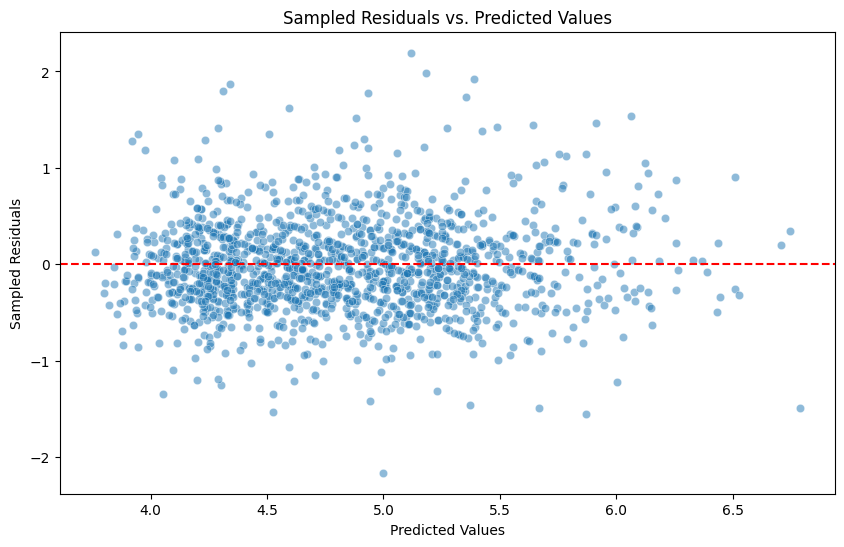

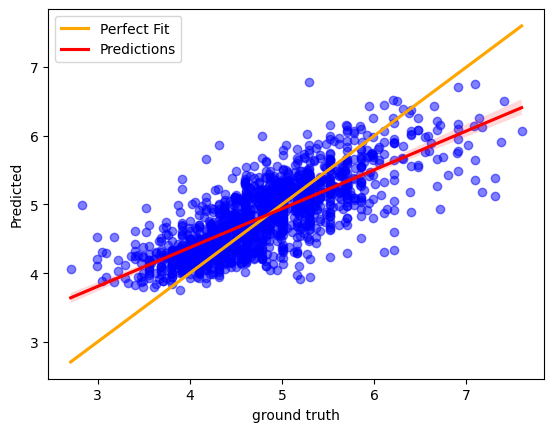

In [148]:
plot_graphs(y_test.squeeze(), y_pred.squeeze(), degree = 1, save = False)


In [149]:
history.history

{'loss': [0.21823351085186005,
  0.2172044813632965,
  0.21733666956424713,
  0.21670937538146973,
  0.21608299016952515,
  0.21713067591190338,
  0.21642321348190308,
  0.21569392085075378,
  0.21547988057136536,
  0.21514566242694855],
 'val_loss': [0.21524028480052948,
  0.2219066619873047,
  0.2129533886909485,
  0.22411102056503296,
  0.21383322775363922,
  0.21356596052646637,
  0.21568641066551208,
  0.21531520783901215,
  0.2134147584438324,
  0.21383772790431976]}

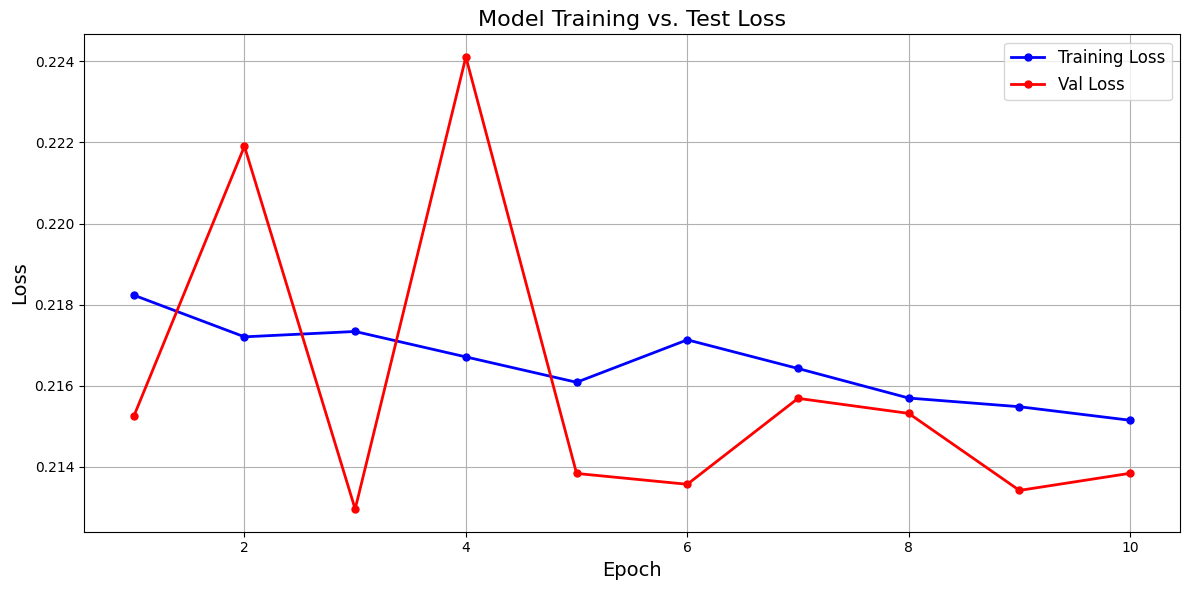

In [73]:
plot_loss_single(history)

### Hyper Tuning

In [15]:
import tensorflow as tf

In [16]:
def build_hp_model(hp):
  model = Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
            activation='relu'))
  model.add(Dense(1))
  learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
  model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
  return model


In [17]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=5,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='checkpoints',
    monitor='loss',
    save_best_only=True,
    save_weights_only= False,
    mode='auto'
)

In [20]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_hp_model,
    objective='val_mean_squared_error',
    max_trials=2,
    seed=10,
    executions_per_trial=3,
    overwrite=True,
    tune_new_entries=True,
    allow_new_entries=True,
    max_consecutive_failed_trials=1
)

In [21]:
# Start searching
tuner_search = tuner.search(X_train, y_train, epochs=10, callbacks=[early_stopping, model_checkpoint], validation_split=0.2)

Trial 2 Complete [00h 00m 42s]
val_mean_squared_error: 0.21478024125099182

Best val_mean_squared_error So Far: 0.21134195228417715
Total elapsed time: 00h 01m 33s


In [22]:
# View summary of searching
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0 summary
Hyperparameters:
num_layers: 3
units_0: 64
learning_rate: 0.0008894905887153519
units_1: 32
units_2: 32
Score: 0.21134195228417715

Trial 1 summary
Hyperparameters:
num_layers: 2
units_0: 32
learning_rate: 0.008520876742029873
units_1: 64
units_2: 96
Score: 0.21478024125099182


In [23]:
# View best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'num_layers': 3,
 'units_0': 64,
 'learning_rate': 0.0008894905887153519,
 'units_1': 32,
 'units_2': 32}

In [39]:
# View best model
# best_model = tuner.get_best_models()[0]
# # build model
# best_model.summary()


In [40]:
best_model = build_hp_model(best_hp)

In [41]:
# Evaluate the best model
loss, acc = best_model.evaluate(X_test, y_test)
print('ACC: ', acc)
print('LOSS: ', loss)

463/463 [==============================] - 0s 388us/step - loss: 22.5218 - mean_squared_error: 22.5218
ACC:  22.5218448638916
LOSS:  22.5218448638916


In [74]:
history_best = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1479/1479 [==============================] - 1s 965us/step - loss: 0.2159 - mean_squared_error: 0.2159 - val_loss: 0.2140 - val_mean_squared_error: 0.2140
Epoch 2/10
1479/1479 [==============================] - 1s 996us/step - loss: 0.2147 - mean_squared_error: 0.2147 - val_loss: 0.2106 - val_mean_squared_error: 0.2106
Epoch 3/10
1479/1479 [==============================] - 1s 879us/step - loss: 0.2154 - mean_squared_error: 0.2154 - val_loss: 0.2124 - val_mean_squared_error: 0.2124
Epoch 4/10
1479/1479 [==============================] - 1s 856us/step - loss: 0.2144 - mean_squared_error: 0.2144 - val_loss: 0.2142 - val_mean_squared_error: 0.2142
Epoch 5/10
1479/1479 [==============================] - 1s 881us/step - loss: 0.2146 - mean_squared_error: 0.2146 - val_loss: 0.2256 - val_mean_squared_error: 0.2256
Epoch 6/10
1479/1479 [==============================] - 1s 877us/step - loss: 0.2136 - mean_squared_error: 0.2136 - val_loss: 0.2211 - val_mean_squared_error: 0.2211
Epoc

463/463 [==============================] - 0s 426us/step


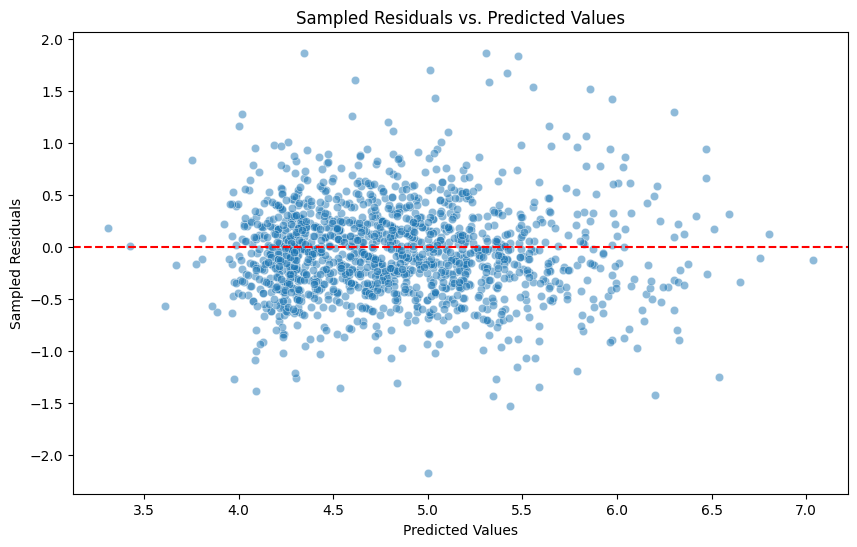

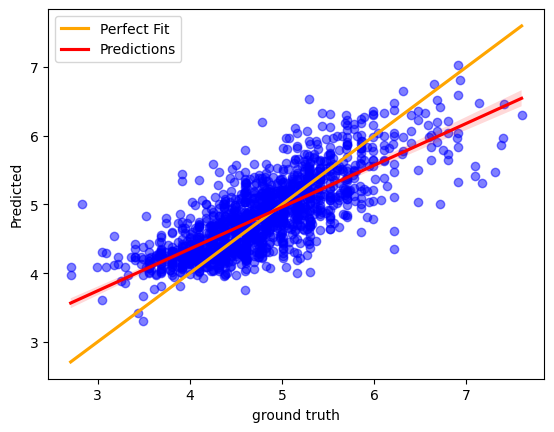

In [153]:
plot_graphs(y_test, best_model.predict(X_test).squeeze(), degree = 1, save = False)

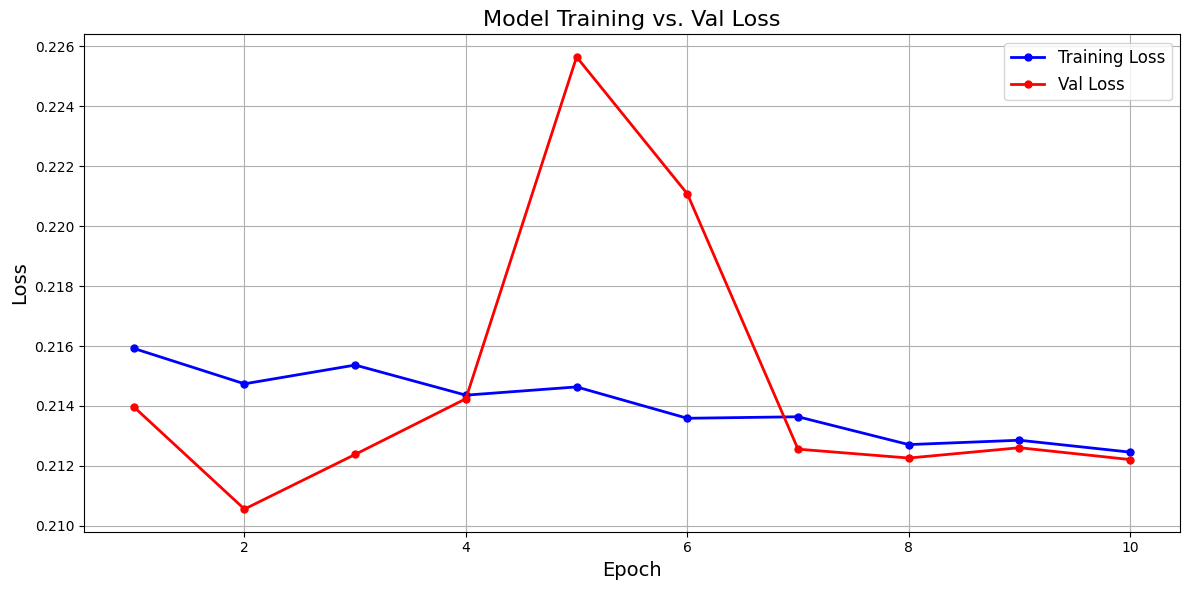

In [78]:
plot_loss_single(history_best)

### Train With XGB

In [28]:
!pip install xgboost

     |████████████████████████████████| 1.9 MB 700 kB/s eta 0:00:01


In [29]:
#Uncomment if first time run
#%pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#hyperparam may need here
param = {
    'max_depth': 5,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}


In [30]:
num_round = 100
evals_result = {}
model = xgb.train(param, dtrain, num_round, evals=[(dtrain, 'train')], evals_result = evals_result, early_stopping_rounds=10)
y_pred = model.predict(dtrain)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print("Train RMSE: %f" % (rmse))
print("Train MSE: %f" % (mse))

[0]	train-rmse:0.60594
[1]	train-rmse:0.54257
[2]	train-rmse:0.50625
[3]	train-rmse:0.48591
[4]	train-rmse:0.47467
[5]	train-rmse:0.46763
[6]	train-rmse:0.46376
[7]	train-rmse:0.46135
[8]	train-rmse:0.45938
[9]	train-rmse:0.45781
[10]	train-rmse:0.45692
[11]	train-rmse:0.45622
[12]	train-rmse:0.45561
[13]	train-rmse:0.45478
[14]	train-rmse:0.45435
[15]	train-rmse:0.45394
[16]	train-rmse:0.45338
[17]	train-rmse:0.45285
[18]	train-rmse:0.45254
[19]	train-rmse:0.45227
[20]	train-rmse:0.45197
[21]	train-rmse:0.45170
[22]	train-rmse:0.45125
[23]	train-rmse:0.45103
[24]	train-rmse:0.45084
[25]	train-rmse:0.45047
[26]	train-rmse:0.45027
[27]	train-rmse:0.45000
[28]	train-rmse:0.44965
[29]	train-rmse:0.44929
[30]	train-rmse:0.44906
[31]	train-rmse:0.44877
[32]	train-rmse:0.44853
[33]	train-rmse:0.44842
[34]	train-rmse:0.44817
[35]	train-rmse:0.44800
[36]	train-rmse:0.44787
[37]	train-rmse:0.44768
[38]	train-rmse:0.44721
[39]	train-rmse:0.44688
[40]	train-rmse:0.44666
[41]	train-rmse:0.44630
[4

In [86]:
evals_result = {}
model = xgb.train(param, dtrain, num_round, evals=[(dtrain, 'train'),(dtest, 'test')],evals_result = evals_result, early_stopping_rounds=10)

y_pred = model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test RMSE: %f" % (rmse))
print("Test MSE: %f" % (mse))

[0]	train-rmse:0.60594	test-rmse:0.61412


[1]	train-rmse:0.54257	test-rmse:0.54937
[2]	train-rmse:0.50625	test-rmse:0.51300
[3]	train-rmse:0.48591	test-rmse:0.49218
[4]	train-rmse:0.47467	test-rmse:0.48134
[5]	train-rmse:0.46763	test-rmse:0.47424
[6]	train-rmse:0.46376	test-rmse:0.47071
[7]	train-rmse:0.46135	test-rmse:0.46860
[8]	train-rmse:0.45938	test-rmse:0.46693
[9]	train-rmse:0.45781	test-rmse:0.46522
[10]	train-rmse:0.45692	test-rmse:0.46442
[11]	train-rmse:0.45622	test-rmse:0.46393
[12]	train-rmse:0.45561	test-rmse:0.46358
[13]	train-rmse:0.45478	test-rmse:0.46290
[14]	train-rmse:0.45435	test-rmse:0.46254
[15]	train-rmse:0.45394	test-rmse:0.46245
[16]	train-rmse:0.45338	test-rmse:0.46227
[17]	train-rmse:0.45285	test-rmse:0.46186
[18]	train-rmse:0.45254	test-rmse:0.46175
[19]	train-rmse:0.45227	test-rmse:0.46171
[20]	train-rmse:0.45197	test-rmse:0.46164
[21]	train-rmse:0.45170	test-rmse:0.46152
[22]	train-rmse:0.45125	test-rmse:0.46125
[23]	train-rmse:0.45103	test-rmse:0.46113
[24]	train-rmse:0.45084	test-rmse:0.46099
[

In [99]:
evals_result['test']['rmse']

[0.6141233195315324,
 0.5493689085405997,
 0.5130033827642174,
 0.49217875808028616,
 0.48133901494597814,
 0.4742417654249506,
 0.470705082111371,
 0.4686010893857823,
 0.4669263647839524,
 0.46522011051103757,
 0.46442327986893395,
 0.46393175028494277,
 0.4635844001780113,
 0.4629015078635626,
 0.46253647812434656,
 0.46244567595002845,
 0.46226900680029387,
 0.4618596427179262,
 0.4617489481248479,
 0.4617095099500433,
 0.4616401669739945,
 0.46151887065072567,
 0.4612492983683932,
 0.46113120968547167,
 0.46099391831194086,
 0.4607789707212819,
 0.4608078667815317,
 0.46090892654771815,
 0.46076853415760916,
 0.46074696811038945,
 0.4606922431587032,
 0.460528287004797,
 0.46043352208067573,
 0.4604015439784222,
 0.4603292836878448,
 0.4603220613116721,
 0.46036749042309205,
 0.4603066116875618,
 0.45995018623030254,
 0.4598570202922101,
 0.459912359620964,
 0.45982325726363404,
 0.4598541774070052,
 0.45977147616805336,
 0.45968910599467183,
 0.4597256862245074,
 0.45971995769217

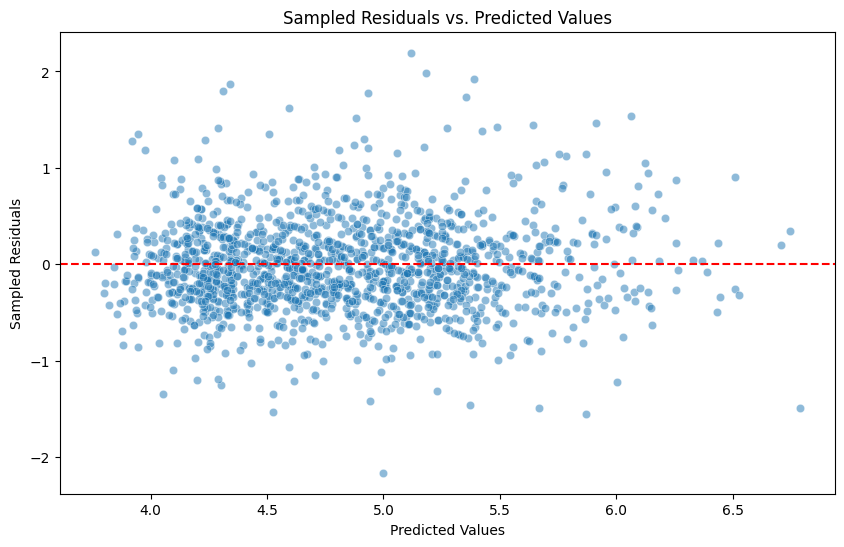

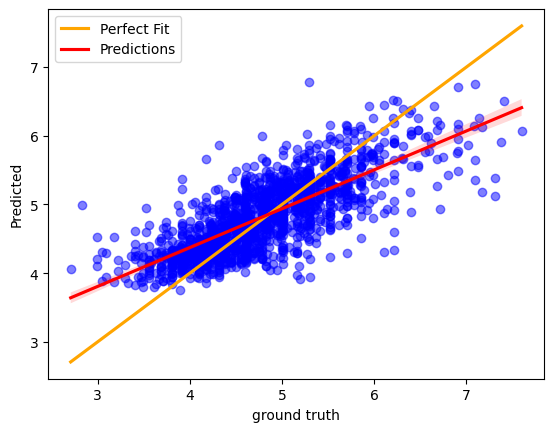

In [157]:
plot_graphs(dtest.get_label(), y_pred.squeeze(), degree = 1, save = False)

In [121]:
# Plotting xboost results
def xboost_graph(evals_result, ax = None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
  
    train_rmse = evals_result['train']['rmse']
    test_rmse = evals_result['test']['rmse']
    x = range(len(train_rmse))
    ax.plot(x, train_rmse, label='Train', color = 'blue')
    ax.plot(x, test_rmse, label='Test', color = 'red')
    ax.legend()
    ax.grid(True)
    ax.set_ylabel('RMSE')  
    ax.set_xlabel('Epochs')
    ax.set_title('XGBoost Train and Test RMSE')

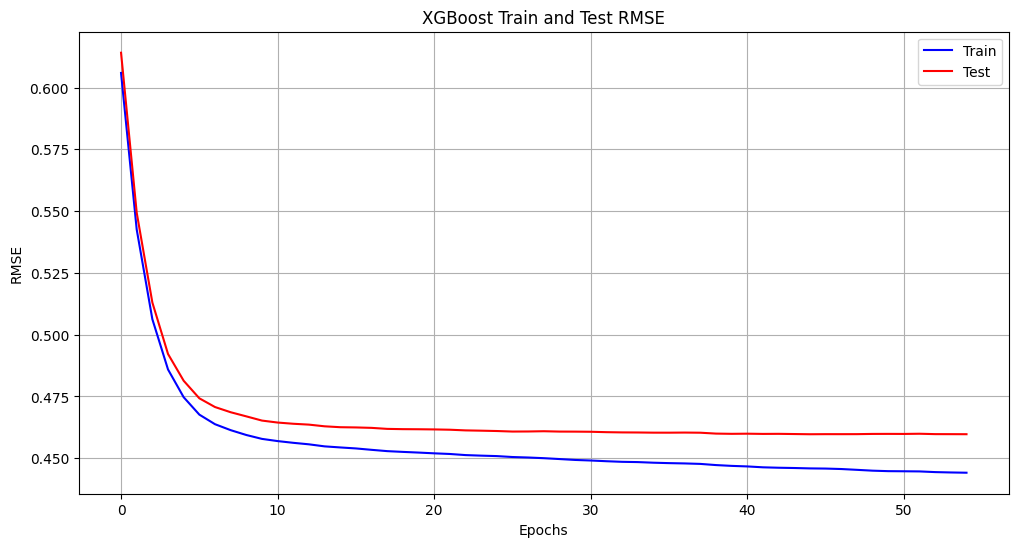

In [122]:
xboost_graph(evals_result)

In [123]:
def plot_loss_single(history, ax = None):
    if ax is None:
       fig,ax = plt.subplots(1, 1, figsize=(12, 6))

    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot training and validation loss
    ax.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=5)
    ax.plot(epochs, history.history['val_loss'], 'ro-', label='Val Loss', linewidth=2, markersize=5)
    
    ax.set_title('Model Training vs. Val Loss', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True)

### Compare different models

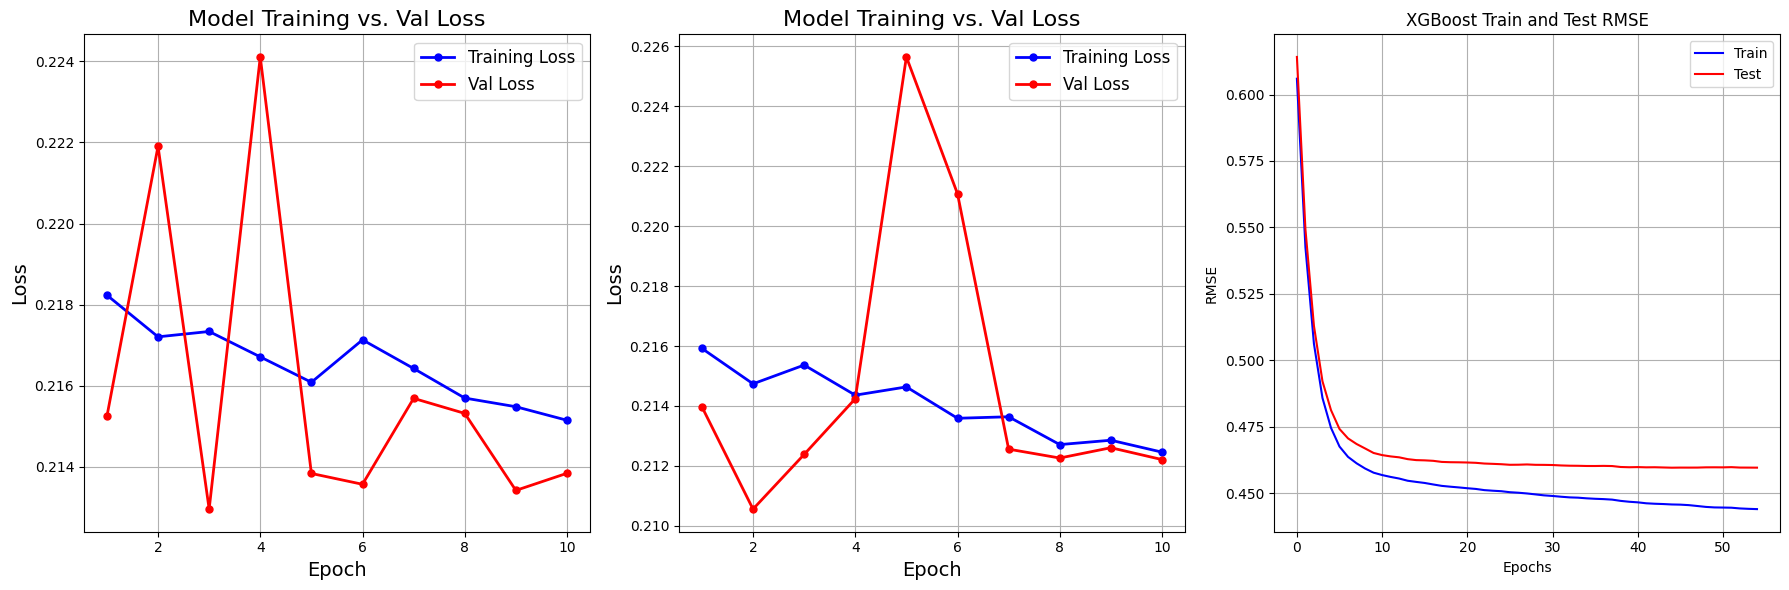

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_loss_single(history,axs[0])
plot_loss_single(history_best,axs[1])
xboost_graph(evals_result,axs[2])
plt.tight_layout()
plt.show()

In [131]:
import seaborn as sns
  
# Plot the residuals
def plot_residuals(df_plot, save = False):
  plt.figure(figsize=(10, 6))
  
  # Plot the residuals
  sns.scatterplot(x='Predicted', y='Residuals', data=df_plot, alpha=0.5)
  
  plt.title('Sampled Residuals vs. Predicted Values')
  plt.xlabel('Predicted Values')
  plt.ylabel('Sampled Residuals')
  
  # Add a horizontal line at y = 0
  plt.axhline(y=0, color='red', linestyle='--') 
  
  
  if save:
    plt.savefig('graphs/residuals.png')
    
    
  plt.show()
  
  
def plot_regression(df_plot, degree,save = False):
  # Plot the truth vs prediction
  sns.regplot(data=df_plot, x='ground truth', y='ground truth', order = degree, ci = None, line_kws=dict(color="orange"), label ='Perfect Fit', scatter_kws={'alpha':0.5}, scatter=False)
  # Plot the polynomial fit
  sns.regplot(data=df_plot, x='ground truth', y='Predicted', order = degree, ci = 99, color='blue', line_kws=dict(color="r",label='Predictions'), scatter_kws={'alpha':0.5})
  
  plt.legend()
  
  if save:
    plt.savefig('graphs/regression.png')



# Plot the graphs
def plot_graphs(y_test, yhat_test, degree = 1,save = False):
  df_plot = pd.DataFrame({'ground truth':y_test, 'Predicted': yhat_test, 'Residuals': y_test-yhat_test})
  df_plot = df_plot[np.abs(df_plot['Residuals']) < 0.9 * np.max(np.abs(df_plot['Residuals']))]
  df_sample = df_plot.sample(frac=0.1,random_state=42)
  plot_residuals(df_sample, save =save)
  plot_regression(df_sample, degree, save =save)

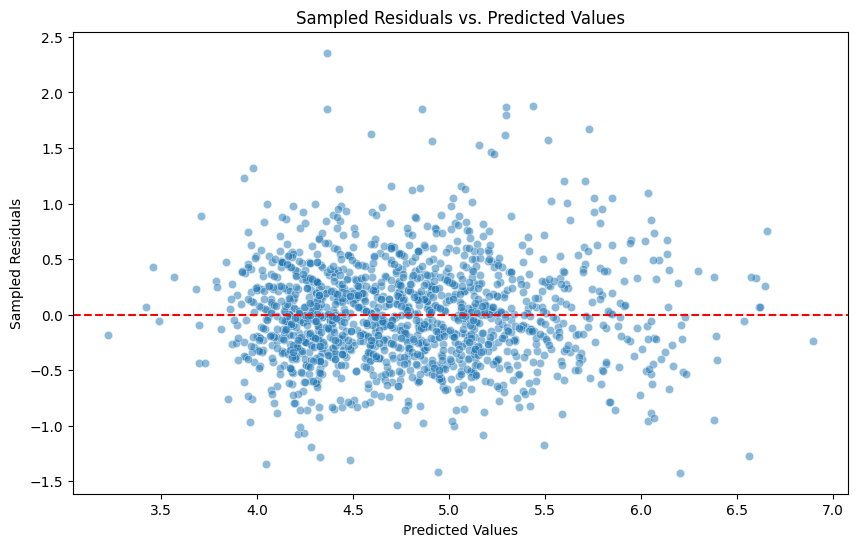

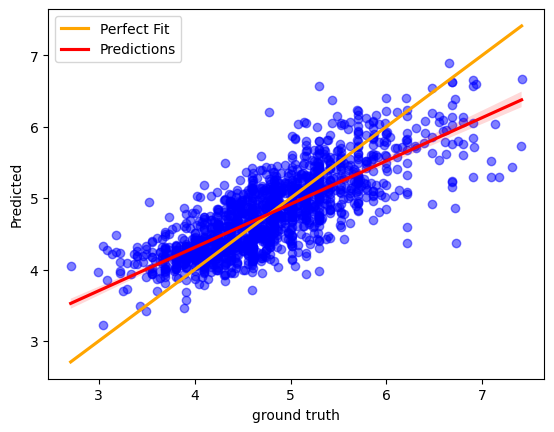

In [132]:
plot_graphs(y_test, y_pred, degree = 1, save = False)